# XoX Sales Analysis and Prediction

## 1. Problem Definition

**Problem statement**
<br>Historical sales data of product XoX has been provided. The product is featured by numerical informations as cost, weight, height, depth and categorical informations as maker, ingredient, product type and product level. All these features and sales history are known to affect future purchase price, but it's challenging to figure out which features are more inportant in predicting a future pruchase

**Feature processing**
<br>Categorical features would be converted to numerical by dummy (one hot) or ordinal (label encoder) transformation
<br>Numerical features would be scaled if necessary (when not tree based model)

**Machine learning**
<br>1, Predict product price (target) for a future pruchase based on given informations (features) by applying regression models
<br>2, Choose the best model (model performance) and interpret the predicted price (feature importance)

**Metrics**
<br>Model performance can be evaluated in different ways, here R2 score is used
<br>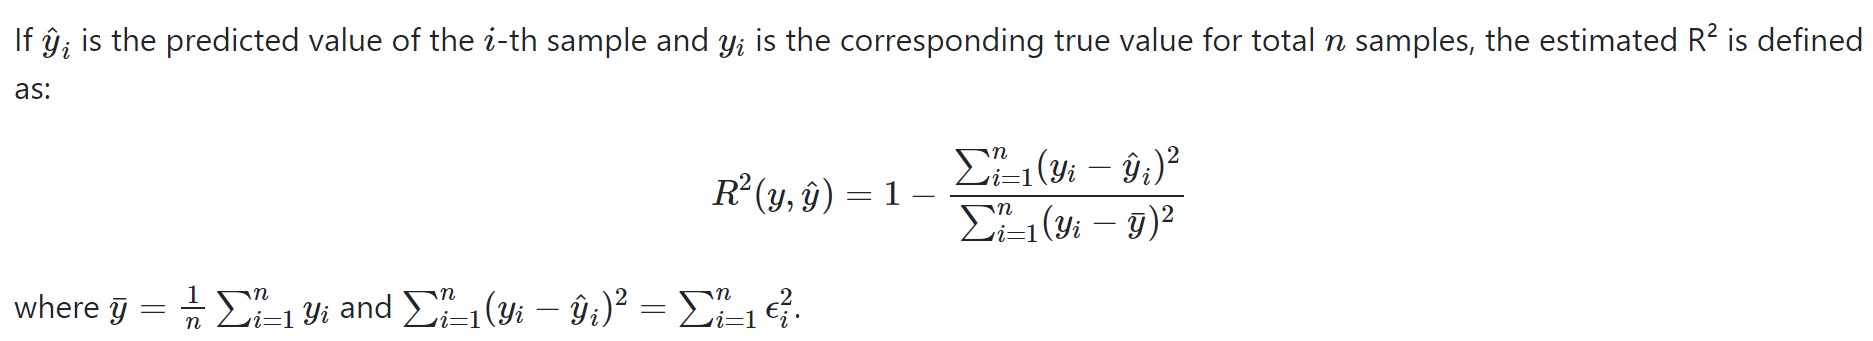
<br>R2 score: the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features). R2 score is no greater than 1 and the higher R2 the better model performance. A negative R2 score suggests that the model performance is worse than mean value prediction, and R2 score of 1 indicates a perfect prediction.

## 2. Pre-model Analysis

In [5]:
# Import libraries | Standard
import pandas as pd
import numpy as np

# Import libraries | Visualization
import seaborn as sns
import matplotlib.pylab as plt

# Import libraries | Sk-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor


# Pretty display for notebooks
%matplotlib inline

In [6]:
# Read the raw data
raw_df = pd.read_csv('../data/sales.csv')
raw_df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [7]:
# Raw data overlook

raw_df.info()
raw_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cost           2216 non-null   object
 1   price          3186 non-null   object
 2   weight         3193 non-null   object
 3   purchase_date  3196 non-null   object
 4   product_type   3196 non-null   object
 5   product_level  3196 non-null   object
 6   maker          2373 non-null   object
 7   ingredient     2941 non-null   object
 8   height         3197 non-null   object
 9   width          3193 non-null   object
 10  depth          3193 non-null   object
dtypes: object(11)
memory usage: 274.9+ KB


,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
count,2216,3186,3193,3196,3196,3196,2373,2941,3197,3193,3193
unique,185,3157,119,1278,64,5,882,2833,161,41,13
top,$66k,"$355,444",3 Ton 0 Kg,Oct 05 2001,D,advanced,M14196,IN732638,2.54 meters,99 cm,26 cm
freq,104,2,127,8,485,1323,17,8,63,268,903


In [8]:
# Missing data

total = raw_df.isnull().sum()
percent = raw_df.isnull().sum()/raw_df.isnull().count()
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).sort_values("Total", ascending=False)
missing_data

,Total,Percent
cost,981,0.306850
maker,824,0.257742
ingredient,256,0.080075
price,11,0.003441
weight,4,0.001251
width,4,0.001251
depth,4,0.001251
purchase_date,1,0.000313
product_type,1,0.000313
product_level,1,0.000313


**Features**
<br>1, Numerical: cost, weight, height, width, depth
<br>2, Categotrical: product_type, product_level, maker, ingredient
<br>3, Datetime: purchase_date

**Target**
<br>- price

**Data type**
<br>All data are objects, need to transform to numerical values for regression analysis

**Missing data**
<br>Cost: ~30% missing, can be replaced with mean value
<br>Maker: ~26% missing, can be replaced with "Unknown"
<br>Ingredient: ~8% missing, can be replaced with "Unknown"
<br>Others: less then 1% missing, can be dropped or replaced by mode (categorical) or mean (numerical)

## 3. Feature Engineering
create features which might improve model performance.

In [9]:
# Drop missing values in target price

df = raw_df.dropna(subset=["price"]).reset_index(drop=True)
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [10]:
# Missing data

total = df.isnull().sum()
percent = df.isnull().sum()/df.isnull().count()
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).sort_values("Total", ascending=False)
missing_data.loc[missing_data["Total"] != 0]

,Total,Percent
cost,975,0.306026
maker,821,0.257690
ingredient,254,0.079724
weight,3,0.000942
width,3,0.000942
depth,3,0.000942


*Only need to deal with missing data in cost, weigth, width, depth, maker and ingredient*

In [11]:
# Transform numerical data to float type and encode categorical data

# convert numerical data to float type
df["price"] = df["price"].map(lambda x: x if not isinstance(x, str) else float(x.strip("$").replace(",", "")))
df["cost"] = df["cost"].map(lambda x: x if not isinstance(x, str) else 1000*float(x.strip("$").strip("k")))    
for dim in ("height", "width", "depth"):
    df[dim] = df[dim].map(lambda x: x if not isinstance(x, str) else float(x.strip(" meters").strip(" cm")))

def weight2num(x):
    '''convert weight X from object to float'''
    if isinstance(x, str):
        x = x.strip(" Kg").replace(" Ton ", " ").split()
        return float(x[0]) * 1000 + float(x[1])
    return float(x)
df["weight"] = df["weight"].map(weight2num)

# convert purchase_date to year, month and day
df["purchase_date"] = pd.to_datetime(df["purchase_date"])
df["year"] = df["purchase_date"].dt.year

temp_df = pd.DataFrame(df["purchase_date"])
temp_df["year"] = temp_df["purchase_date"].dt.year
temp_df["month"] = temp_df["purchase_date"].dt.month
temp_df["day"] = temp_df["purchase_date"].dt.day
temp_df["days_in_month"] = [pd.Period(str(date)).days_in_month for date in temp_df["purchase_date"].dt.date]
temp_df["day_percent"] = temp_df["day"] / temp_df["days_in_month"]
temp_df["sin_month"] = temp_df["month"].map(lambda x: np.sin(2*np.pi*x/12))
temp_df["cos_month"] = temp_df["month"].map(lambda x: np.cos(2*np.pi*x/12))
temp_df["sin_day"] = temp_df["day_percent"].map(lambda x: np.sin(2*np.pi*x))
temp_df["cos_day"] = temp_df["day_percent"].map(lambda x: np.cos(2*np.pi*x))

df["sin_month"] = temp_df["sin_month"]
df["cos_month"] = temp_df["cos_month"]
df["sin_day"] = temp_df["sin_day"]
df["cos_day"] = temp_df["cos_day"]
df = df.drop(columns="purchase_date")

# label product_level, considering low to high: unrated, basic, intermediate, advanced, super advanced
pl_convert = {"unrated": 0, "basic": 1, "intermediate": 2, "advanced": 3, "super advanced": 4}
df["product_level"] = df["product_level"].map(lambda x: pl_convert[x])

# label product_type, maker and ingredient
for cate in ("product_type", "maker", "ingredient"):
    convert = {}
    i = 1
    for item in df[cate][df[cate].notnull()]:
        if item not in convert:
            convert[item] = i
            i += 1
    df[cate] = df[cate].map(lambda x: convert[x], na_action="ignore")

df.head()

,cost,price,weight,product_type,product_level,maker,ingredient,height,width,depth,year,sin_month,cos_month,sin_day,cos_day
0,333000.0,300492.0,3090.0,1,3,1.0,1.0,2.76,97.0,26.0,2008,-2.449294e-16,1.000000e+00,-0.651372,-0.758758
1,NaN,430570.0,3030.0,2,1,NaN,2.0,2.67,98.0,26.0,1997,-1.000000e+00,-1.836970e-16,0.866025,-0.500000
2,270000.0,213070.0,3040.0,2,1,NaN,3.0,3.00,93.0,24.0,2001,-1.000000e+00,-1.836970e-16,0.866025,0.500000
3,NaN,229174.0,3050.0,3,3,2.0,4.0,2.50,102.0,27.0,2016,-2.449294e-16,1.000000e+00,-0.998717,-0.050649
4,97000.0,122659.0,2970.0,4,3,NaN,5.0,2.47,101.0,26.0,2000,5.000000e-01,8.660254e-01,0.651372,-0.758758


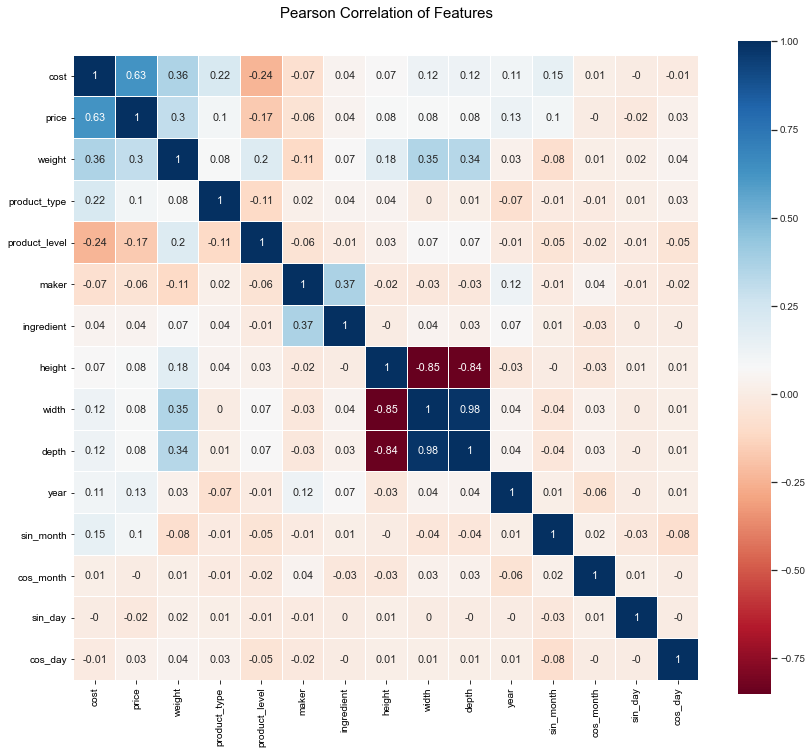

In [12]:
# Analysis feature correlation

def pea_corr(df):
    '''helper function for correlation analysis'''
    colormap = plt.cm.RdBu
    corr = df.astype(float).corr()

    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.set(font_scale=0.9)
    sns.heatmap(round(corr,2),linewidths=0.1,vmax=1.0, square=True, 
                cmap=colormap, linecolor='white', annot=True)
    plt.show()

pea_corr(df)

*Height, width and depth are highly correlated features, thus can be replaced by one feature volume, which is the product of the three. Cost and price are intermediately correlated*

In [13]:
# Replacing features height, width and depth with volume
df["volume"] = df["height"] * df["width"] * df["depth"]
df = df.drop(columns=["height", "width", "depth"])
df.head()

,cost,price,weight,product_type,product_level,maker,ingredient,year,sin_month,cos_month,sin_day,cos_day,volume
0,333000.0,300492.0,3090.0,1,3,1.0,1.0,2008,-2.449294e-16,1.000000e+00,-0.651372,-0.758758,6960.72
1,NaN,430570.0,3030.0,2,1,NaN,2.0,1997,-1.000000e+00,-1.836970e-16,0.866025,-0.500000,6803.16
2,270000.0,213070.0,3040.0,2,1,NaN,3.0,2001,-1.000000e+00,-1.836970e-16,0.866025,0.500000,6696.00
3,NaN,229174.0,3050.0,3,3,2.0,4.0,2016,-2.449294e-16,1.000000e+00,-0.998717,-0.050649,6885.00
4,97000.0,122659.0,2970.0,4,3,NaN,5.0,2000,5.000000e-01,8.660254e-01,0.651372,-0.758758,6486.22


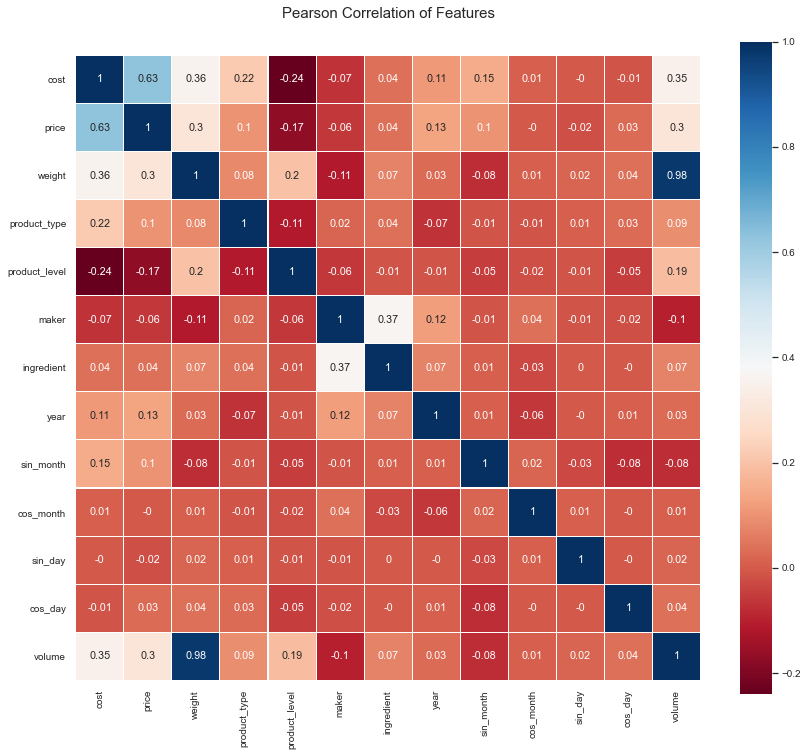

In [14]:
# Analysis feature correlation

pea_corr(df)

*Weigth and volume are highly correlated, thus drop the feature volume*

In [15]:
df = df.drop(columns="volume")
df.head()

,cost,price,weight,product_type,product_level,maker,ingredient,year,sin_month,cos_month,sin_day,cos_day
0,333000.0,300492.0,3090.0,1,3,1.0,1.0,2008,-2.449294e-16,1.000000e+00,-0.651372,-0.758758
1,NaN,430570.0,3030.0,2,1,NaN,2.0,1997,-1.000000e+00,-1.836970e-16,0.866025,-0.500000
2,270000.0,213070.0,3040.0,2,1,NaN,3.0,2001,-1.000000e+00,-1.836970e-16,0.866025,0.500000
3,NaN,229174.0,3050.0,3,3,2.0,4.0,2016,-2.449294e-16,1.000000e+00,-0.998717,-0.050649
4,97000.0,122659.0,2970.0,4,3,NaN,5.0,2000,5.000000e-01,8.660254e-01,0.651372,-0.758758


## 4. Modeling
Model selection, feature elimination, validation, hyperparameter tuning.

In [16]:
# Set train and test data

train_raw = df[df["year"] < 2015].reset_index(drop=True)
test_raw = df[df["year"] >= 2015].reset_index(drop=True)

features = list(df.columns)
target = "price"
features.remove(target)

X_train = train_raw[features]
y_train = train_raw[target]

X_test = test_raw[features]
y_test = test_raw[target]

In [17]:
# Transformer class to deal with missing values

class Transformer():
    def fit(self, X, y=None):
        self.cost_mean = X["cost"].mean()
        self.weight_mean = X["weight"].mean()
        self.maker_fill = 0.
        self.ingr_fill = 0.
        
    def transform(self, X, y=None):
        df = X.copy()
        df["cost"].fillna(self.cost_mean, inplace=True)
        df["weight"].fillna(self.weight_mean, inplace=True)
        df["maker"].fillna(self.maker_fill, inplace=True)
        df["ingredient"].fillna(self.ingr_fill, inplace=True)
        return df
        
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [18]:
# Three base models: linear regression, random forest and xgboost

steps_lr = [("ctf", Transformer()), ("scale", MinMaxScaler()), ("lr", LinearRegression())]
steps_rf = [("ctf", Transformer()), ("rf", RandomForestRegressor(random_state=42))]
steps_xgb = [("ctf", Transformer()), ("xbg", XGBRegressor(random_state=42, objective='reg:squarederror'))]

model_lr = Pipeline(steps_lr)
model_rf = Pipeline(steps_rf)
model_xgb = Pipeline(steps_xgb)

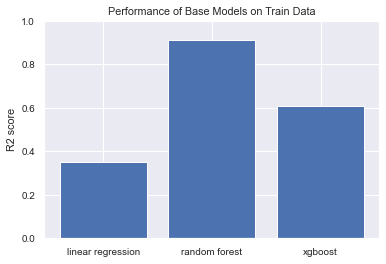

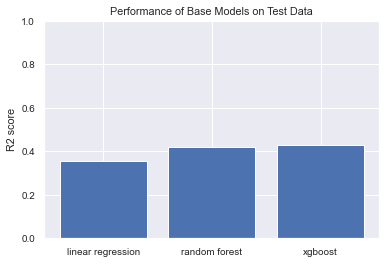

In [19]:
# Compare the base models

models = {"linear regression": model_lr, "random forest": model_rf, "xgboost": model_xgb}
train_res = {}
test_res = {}

for name, model in models.items():
    model = model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_res[name] = r2_score(y_train, y_train_pred)
    y_test_pred = model.predict(X_test)
    test_res[name] = r2_score(y_test, y_test_pred)
    
fig_train = plt.figure()
plt.bar(train_res.keys(), train_res.values())
plt.title("Performance of Base Models on Train Data")
plt.ylabel("R2 score")
plt.ylim(0, 1)
plt.show()

fig_train = plt.figure()
plt.bar(test_res.keys(), test_res.values())
plt.title("Performance of Base Models on Test Data")
plt.ylabel("R2 score")
plt.ylim(0, 1)
plt.show()

In [20]:
print(train_res)
print(test_res)

{'linear regression': 0.3528459082441353, 'random forest': 0.913741756015526, 'xgboost': 0.6097045979724336}
{'linear regression': 0.3538007402037029, 'random forest': 0.42064896955858533, 'xgboost': 0.43072718902986773}


**Base model selection**
<br>Comparing the R2 scores of the three base models on both train and test data, xgboost gives the best performance. Hence xgboost is chose as our base model. Hyper parameter tuning will be conducted to further improve the model performance.

In [26]:
# Gridserach to find the best hyper parameters

params = {
#      "xgbr__n_estimators": [100, 300],
#      "xgbr__learning_rate": [0.05, 0.1],
#      "xgbr__max_depth": [2, 3],
     "xgbr__reg_alpha": [0, 0.5, 0.3],
     "xgbr__reg_lambda": [0, 0.1, 1]
}


steps = [("ctf", Transformer()),
         ("xgbr", XGBRegressor(random_state=42, objective='reg:squarederror'))]

model = Pipeline(steps)

scorer = make_scorer(r2_score)

clf = GridSearchCV(model, params, scoring=scorer)

clf.fit(X_train, y_train)

results = clf.cv_results_
best_model = clf.best_estimator_
best_params = clf.best_params_

In [27]:
best_model

Pipeline(steps=[('ctf', <__main__.Transformer object at 0x000001675FFC6AC8>),
                ('xgbr',
                 XGBRegressor(objective='reg:squarederror', random_state=42,
                              reg_alpha=0.5))])

In [28]:
best_params

{'xgbr__reg_alpha': 0.5, 'xgbr__reg_lambda': 1}

In [29]:
model = best_model.fit(X_train, y_train)

In [30]:
y_train_pred = model.predict(X_train)
print("Train R2: {:.3f}".format(r2_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print("Test R2: {:.3f}".format(r2_score(y_test, y_test_pred)))

Train R2: 0.610
Test R2: 0.431


*After tuning, both the train and test R2 score are improved by 0.001*

**Best model**
<br>Pipeline(steps=[('ctf', Transformer()),
                ('xgbr',
                 XGBRegressor(objective='reg:squarederror', random_state=42,
                              reg_alpha=10))])

**Best performance** 
<br>train R2 = 0.610, test R2 = 0.431

## 5. Post-model Analysis
Model performance, feature importance, actionable suggestions to business.

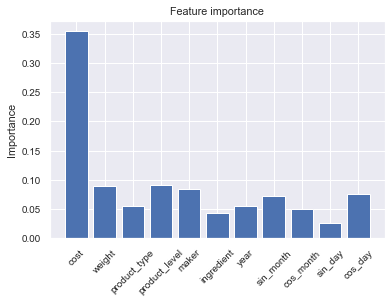

In [31]:
# Feature importance

x = range(1, 12)
fea = X_train.columns
y = model[1].feature_importances_
plt.bar(x, y)
plt.title("Feature importance")
plt.xticks(x, fea, rotation=45)
plt.ylabel("Importance")
plt.show()

*The determining feature is cost, other moderately important features are weight, product_level and maker*

**Summary**
<br>1, We eliminated correlated features (dimensions) in the data set, and compared the performance of three base models: linear regression, random forest and xgboost. Xgboost was selected as the base model
<br>2, We tuned the model hyperparameters and the final best model gives a moderate R2 score of 0.610 (train) and 0.431 (test)
<br>3, The most important feature that determines the product price is the cost, other related factors are weight, product_level, and maker. 

**Suggestions**
<br>The product price highly depends on the cost. Pay attention to the cost, weight, product level and maker of the product before purchase.